# Image processing
Here I clear choose classes, clear data and build model.

In [2]:
import numpy as np

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00


After extracting data I saved it and maybe push on github

In [4]:
from datasets import load_dataset
dataset = load_dataset("cifar100")

train_images = np.array([example['img'] for example in dataset['train']])
train_fine_labels = np.array([example['fine_label'] for example in dataset['train']])
train_coarse_labels = np.array([example['coarse_label'] for example in dataset['train']])

test_images = np.array([example['img'] for example in dataset['test']])
test_fine_labels = np.array([example['fine_label'] for example in dataset['test']])
test_coarse_labels = np.array([example['coarse_label'] for example in dataset['test']])

np.savez("cifar100_data.npz",
         train_images=train_images,
         train_fine_labels=train_fine_labels,
         train_coarse_labels=train_coarse_labels,
         test_images=test_images,
         test_fine_labels=test_fine_labels,
         test_coarse_labels=test_coarse_labels)

print("Dataset saved successfully as cifar100_data.npz")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset saved successfully as cifar100_data.npz


In [5]:
data = np.load("cifar100_data.npz")

train_images = data['train_images']
train_fine_labels = data['train_fine_labels']
train_coarse_labels = data['train_coarse_labels']

test_images = data['test_images']
test_fine_labels = data['test_fine_labels']
test_coarse_labels = data['test_coarse_labels']

print(train_images.shape)
print(test_images.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
train_fine_labels.shape

(50000,)

## Training dataset
Here I clear train data

In [7]:
filtered_train_images = np.zeros([50000,32,32,3])
filtered_train_labels = np.zeros([50000])

In [8]:
n=0
for i in train_fine_labels:
    if i in [72, 30,95,73,97,88,3,31,66,79]:
        filtered_train_images[n] = train_images[n]
        filtered_train_labels[n] = i
    n+=1
    #print(n)

In [9]:
mask = filtered_train_labels != 0
filtered_train_labels = filtered_train_labels[mask]
filtered_train_images = train_images[mask]
print(filtered_train_labels.shape)
print(filtered_train_images.shape)

(5000,)
(5000, 32, 32, 3)


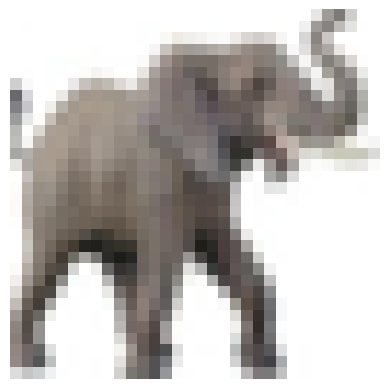

In [10]:
import matplotlib.pyplot as plt
plt.imshow(filtered_train_images[0])
plt.axis('off')
plt.show()

In [11]:
filtered_train_labels[0] #if 31 it means that elephant is displayed on image

31.0

## Test dataset
All the same for test data

In [12]:
filtered_test_images = np.zeros([50000,32,32,3])
filtered_test_labels = np.zeros([50000])
n=0
for i in test_fine_labels:
    if i in [72, 30,95,73,97,88,3,31,66,79]:
        filtered_test_images[n] = test_images[n]
        filtered_test_labels[n] = i
    n+=1
    #print(n)

In [13]:
desired_classes = [72, 30, 95, 73, 97, 88, 3, 31, 66, 79]
mask = np.isin(test_fine_labels, desired_classes)
filtered_test_images = test_images[mask]
filtered_test_labels = test_fine_labels[mask]
print(filtered_test_images.shape)
print(filtered_test_labels.shape)

(1000, 32, 32, 3)
(1000,)


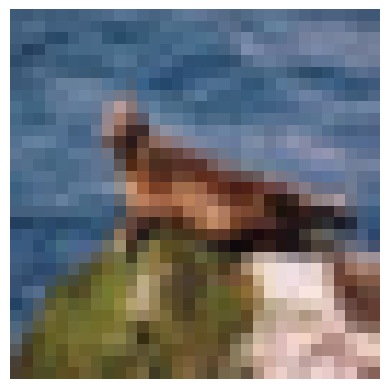

In [14]:
plt.imshow(filtered_test_images[0])
plt.axis('off')
plt.show()

In [15]:
filtered_test_labels[0] # looks like a seal idk (72 coresponds to seal class)

72

## Model
Here i build model but first i should normilize my classes

In [16]:
class_map = {72: 0, 30: 1, 95: 2, 73: 3, 97: 4, 88: 5, 3: 6, 31: 7, 66: 8, 79: 9 }

y_train_remapped = np.array([class_map[label] for label in filtered_train_labels])
y_test_remapped = np.array([class_map[label] for label in filtered_test_labels])

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
class ImageClassifier32:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.model = Sequential([
            Input(shape=(32, 32, 3)),
            Conv2D(32, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.25),
            Conv2D(64, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.25),
            Conv2D(128, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.25),
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        self.model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    def preprocess_data(self, x):
        return x / 255.0

    def train(self, x_train, y_train, x_val, y_val, epochs=20, batch_size=32):
        x_train = self.preprocess_data(x_train)
        x_val = self.preprocess_data(x_val)
        history = self.model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size)
        self.model.save("image_classifier_32x32.h5")

    def test(self, x_test, y_test):
        x_test = self.preprocess_data(x_test)
        loss, accuracy = self.model.evaluate(x_test, y_test)
        print(f"Accuracy: {accuracy:.4f}")
        return accuracy

    def fine_tune(self, x_train, y_train, x_val, y_val, freeze_until=-1, epochs=5, batch_size=32, learning_rate=1e-5):
        for layer in self.model.layers[:freeze_until]:
            layer.trainable = False
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        x_train = self.preprocess_data(x_train)
        x_val = self.preprocess_data(x_val)
        history = self.model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size)
        self.model.save("fine_tuned_image_classifier_32x32.h5")


As Accuracy was poor, I added tuning to one class for better performance.

In [18]:
model = ImageClassifier32(num_classes=10)
model.train(filtered_train_images, y_train_remapped, filtered_test_images, y_test_remapped, epochs=20, batch_size=32)

model.fine_tune(filtered_train_images, y_train_remapped, filtered_test_images, y_test_remapped, freeze_until=-1, epochs=5, batch_size=32, learning_rate=1e-5)

model.test(filtered_train_images, y_train_remapped)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 170ms/step - accuracy: 0.2621 - loss: 2.5925 - val_accuracy: 0.1000 - val_loss: 5.9136
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.3762 - loss: 1.8615 - val_accuracy: 0.1040 - val_loss: 4.4004
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.4256 - loss: 1.6411 - val_accuracy: 0.2560 - val_loss: 2.3668
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.4822 - loss: 1.4548 - val_accuracy: 0.4480 - val_loss: 1.6084
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.4995 - loss: 1.3829 - val_accuracy: 0.4870 - val_loss: 1.5050
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.5255 - loss: 1.3063 - val_accuracy: 0.4930 - val_loss: 1.4636
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5503 - loss: 1.2623 - val_accuracy: 0.5450 - val_loss: 1.2393
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5727 - loss: 1

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6093 - loss: 1.4644 - val_accuracy: 0.5090 - val_loss: 1.8163
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.6064 - loss: 1.3944 - val_accuracy: 0.5130 - val_loss: 1.7983
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6154 - loss: 1.4970 - val_accuracy: 0.5150 - val_loss: 1.7811
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6249 - loss: 1.3224 - val_accuracy: 0.5180 - val_loss: 1.7650
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6182 - loss: 1.4800 - val_accuracy: 0.5220 - val_loss: 1.7481


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7486 - loss: 1.0969
Accuracy: 0.7436


AttributeError: 'ImageClassifier32' object has no attribute 'save'